For reason unknown, the output of the untrained model has to be computed before instantiating the trained model (loading checkpoint), otherwise the untrained model will have trained parameters.

In [45]:
import pytorch_lightning as pl
import monai
import torch
import hydra
from src.model import RetinaUNet
import matplotlib.pyplot as plt
import torchmetrics
import sklearn.metrics
from tqdm import tqdm
import numpy as np
import yaml
import shutil
import os

In [2]:
with hydra.initialize(config_path="configs", version_base=None, job_name="training"):
    cfg = hydra.compose(config_name="config.yaml")

In [3]:
datamodule = hydra.utils.instantiate(cfg['datamodule'])

backbone = torch.nn.Sequential(
    hydra.utils.instantiate(cfg['backbone']),
    torch.nn.Sigmoid()
)

optimizer = hydra.utils.instantiate(cfg['optimizer'], params=backbone.parameters())
scheduler = hydra.utils.instantiate(cfg['scheduler'], optimizer=optimizer)
loss_function = hydra.utils.instantiate(cfg['loss'])
metric = hydra.utils.instantiate(cfg['metric'])

In [4]:
# Get data
datamodule.prepare_data()
datamodule.setup('test')
test_ds = datamodule.test_dataset

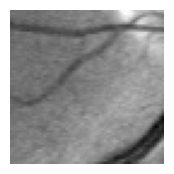

In [5]:
# Data example
idx = 0

plt.figure(figsize=(2, 2))
plt.imshow(test_ds[idx]['image'].numpy().transpose(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

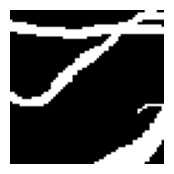

In [6]:
# GT mask
plt.figure(figsize=(2, 2))
plt.imshow(test_ds[idx]['mask'].numpy().transpose(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# Untrained model
model_untrained = hydra.utils.instantiate(
    cfg['model'], 
    backbone=backbone, 
    loss_function=loss_function, 
    metric=metric, 
    optimizer=optimizer,
    scheduler=scheduler
)

model_untrained = model_untrained.eval()

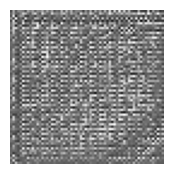

In [8]:
# Untrained model prediction
untrained_output = model_untrained(test_ds[idx]['image'].unsqueeze(0))

plt.figure(figsize=(2, 2))
plt.imshow(untrained_output.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Trained model
# (the checkpoint loading as we do it)
model_trained = hydra.utils.instantiate(
    cfg['model'], 
    backbone=backbone, 
    loss_function=loss_function, 
    metric=metric, 
    optimizer=optimizer,
    scheduler=scheduler
)

model_trained = model_trained.load_from_checkpoint(
    cfg['best_model_checkpoint'],
    backbone=backbone, 
    loss_function=loss_function, 
    metric=metric, 
    optimizer=optimizer,
    scheduler=scheduler
)

model_trained = model_trained.eval()

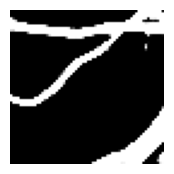

In [10]:
# Trained model prediction
trained_output = model_trained(test_ds[idx]['image'].unsqueeze(0))

plt.figure(figsize=(2, 2))
plt.imshow(trained_output.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# <ins> PROPER TESTING

## TRAINER TEST

In [15]:
from src.utils import instantiate_callbacks
callbacks = instantiate_callbacks(cfg['callbacks'])
# logger = pl.loggers.CSVLogger(save_dir='', name='test')
trainer = hydra.utils.instantiate(cfg['trainer'], callbacks=callbacks, logger=None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
dice = trainer.test(
    model=model_trained, 
    datamodule=datamodule,
    ckpt_path=cfg['best_model_checkpoint']
)

Restoring states from the checkpoint path at /home/gpievanitrapletti/retina/logs/runs/retina_segmentation/2023-03-09_11-50-36/checkpoints/epoch_epoch=049.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /home/gpievanitrapletti/retina/logs/runs/retina_segmentation/2023-03-09_11-50-36/checkpoints/epoch_epoch=049.ckpt


Testing DataLoader 0: 100%|██████████| 742/742 [00:20<00:00, 35.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_metric          0.7368622422218323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [29]:
dice

[{'test_metric': 0.7368622422218323}]

## AUC

In [23]:
datamodule.prepare_data()
datamodule.setup('test')
test_ds = datamodule.test_dataset
test_dl = datamodule.test_dataloader()

In [24]:
outputs = []
with torch.no_grad():
    for batch in tqdm(test_dl):
        images, gts = batch["image"], batch["mask"]
        gts = torch.where(gts > 0, 1, 0).astype(torch.float32)
        # images, gts = images.to(device), gts.to(device)
        preds = model_trained(images)
        preds = torch.where(preds > 0.5, True, False).astype(torch.float32)
        outputs.append(preds.numpy())

outputs = np.concatenate(outputs)

100%|██████████| 742/742 [00:15<00:00, 48.72it/s]


In [25]:
type(outputs), outputs.shape, outputs.dtype

(numpy.ndarray, (742, 1, 64, 64), dtype('float32'))

In [26]:
gts = np.concatenate([test_ds[i]['mask'].numpy()[None, ...] for i in range(len(test_ds))])
gts.shape

(742, 1, 64, 64)

In [52]:
aucs = []
for i in range(len(outputs)):
    pred = outputs[i][0, ...]
    gt = gts[i][0, ...]
    auc = sklearn.metrics.roc_auc_score(gt.flatten(), pred.flatten())
    aucs.append(auc)

auroc = float(np.round(np.mean(aucs), 3))

In [53]:
performances = {
    'dice': round(dice[0]['test_metric'], 3),
    'auroc': auroc
}

performances

{'dice': 0.737, 'auroc': 0.865}

In [55]:
with open('performances.yaml', 'w') as file:
    yaml.dump(performances, file)

# <ins> SAVE EXAMPLES OF PREDICTIONS

In [80]:
# # Save original tile + GT mask + predicted mask
# if os.path.exists('results'):
#     shutil.rmtree('results')
# os.makedirs('results')

# rand_idxs = np.random.choice(list(range(len(gts))), 20, replace=False)

# for idx in rand_idxs:
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

#     axes[0].imshow(test_ds[idx]['original_image'].squeeze(), cmap='gray')
#     axes[0].set_title('Tile')
#     axes[0].axis('off')

#     axes[1].imshow(gts[idx].squeeze(), cmap='gray')
#     axes[1].set_title('GT mask')
#     axes[1].axis('off')

#     axes[2].imshow(outputs[idx].squeeze() > 0.5, cmap='gray')
#     axes[2].set_title('Pred mask')
#     axes[2].axis('off')

#     plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1) # spacing
#     save = plt.savefig(f'results/{idx}.png')
#     plt.close(fig)